In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import ast
from google.colab import drive
from sklearn.model_selection import train_test_split, KFold
from datetime import datetime, time
from sklearn.metrics import mean_squared_error

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
review_file_path = '/content/drive/MyDrive/BT4222/Group Project/data/review_final.csv'
restaurant_file_path = '/content/drive/MyDrive/BT4222/Group Project/data/restaurants_final.csv'

review_df = pd.read_csv(review_file_path)
restaurant_df = pd.read_csv(restaurant_file_path)

In [4]:
restaurant_df.drop(columns='Unnamed: 0', inplace=True)

# Train-Test Split

In [5]:
review_df['date'] = pd.to_datetime(review_df['date'])


review_train_df = review_df[review_df['date'] < '2021-01-01']
review_test_df = review_df[review_df['date'] >= '2021-01-01']

## Reprocessed weighted_stars for train and test dataset
To prevent information leakage, train data should only be calculated using data available before 2021-01-01. Similarly, test data should be calculated using data available before 2022-01-19 (which is the entire dataset)

In [6]:
baseline_date = datetime(2021, 1, 1) # Use 1 day after the latest date available as the baseline date for processing
review_train_df['review_age_days'] = (baseline_date - pd.to_datetime(review_train_df['date'])).dt.days

# Function to apply time decay
def apply_time_decay(df, decay_factor):
    df = df.copy()
    df.loc[:, 'review_weight'] = np.exp(-df['review_age_days'] / decay_factor)
    df.loc[:, 'weighted_stars'] = df['stars'] * df['review_weight']
    return df

# Split data into 80% train, 20% test
train_data, test_data = train_test_split(review_train_df, test_size=0.2, random_state=42)

# Cross-validation with 80% training data using decay factors in multiples of 365
decay_factors = [365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 4015, 4380, 4745, 5110, 5475, 5840, 6205, 6570, 6935, 7000]
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for decay in decay_factors:
    mse_scores = []

    for train_index, val_index in kf.split(train_data):
        train_df, val_df = train_data.iloc[train_index].copy(), train_data.iloc[val_index].copy()

        # Apply time decay
        train_df = apply_time_decay(train_df, decay)
        val_df = apply_time_decay(val_df, decay)

        # Compute mean weighted rating per business
        business_avg_weighted_rating = train_df.groupby('business_id')['weighted_stars'].mean().fillna(0)

        # Predict validation ratings using the business averages
        val_df.loc[:, 'predicted_rating'] = val_df['business_id'].map(business_avg_weighted_rating).fillna(3)

        # Compute MSE
        mse = mean_squared_error(val_df['stars'], val_df['predicted_rating'])
        mse_scores.append(mse)

    # Store average MSE for this decay factor
    cv_results[decay] = np.mean(mse_scores)

# Find the best decay factor
best_decay = min(cv_results, key=cv_results.get)
print("Best Decay Factor:", best_decay)
print("Cross-validation MSE Scores:", cv_results)

# Apply the best decay factor to the dataset
review_train_df = apply_time_decay(review_train_df.copy(), best_decay)

<ipython-input-6-39bd0f5860a2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  review_train_df['review_age_days'] = (baseline_date - pd.to_datetime(review_train_df['date'])).dt.days


Best Decay Factor: 7000
Cross-validation MSE Scores: {365: np.float64(13.484637803773163), 730: np.float64(10.732079197135864), 1095: np.float64(8.63958626408529), 1460: np.float64(7.117927324485095), 1825: np.float64(6.008069354746342), 2190: np.float64(5.185202556798379), 2555: np.float64(4.563025378675784), 2920: np.float64(4.08338912082179), 3285: np.float64(3.706939879971472), 3650: np.float64(3.4066428496578736), 4015: np.float64(3.1635832555645216), 4380: np.float64(2.9642766027999907), 4745: np.float64(2.7989341418606535), 5110: np.float64(2.660328430611946), 5475: np.float64(2.543038779883635), 5840: np.float64(2.4429405227479846), 6205: np.float64(2.3568533349506464), 6570: np.float64(2.282295068940955), 6935: np.float64(2.217306757814484), 7000: np.float64(2.2066131913110225)}


In [7]:
aseline_date = datetime(2022, 1, 20) # Similarly use one day after latest available date
review_df['review_age_days'] = (baseline_date - pd.to_datetime(review_df['date'])).dt.days

# Function to apply time decay
def apply_time_decay(df, decay_factor):
    df = df.copy()
    df.loc[:, 'review_weight'] = np.exp(-df['review_age_days'] / decay_factor)
    df.loc[:, 'weighted_stars'] = df['stars'] * df['review_weight']
    return df

# Split data into 80% train, 20% test
train_data, test_data = train_test_split(review_df, test_size=0.2, random_state=42)

# Cross-validation with 80% training data using decay factors in multiples of 365
decay_factors = [365, 730, 1095, 1460, 1825, 2190, 2555, 2920, 3285, 3650, 4015, 4380, 4745, 5110, 5475, 5840, 6205, 6570, 6935, 7000]
cv_results = {}
kf = KFold(n_splits=5, shuffle=True, random_state=42)

for decay in decay_factors:
    mse_scores = []

    for train_index, val_index in kf.split(train_data):
        train_df, val_df = train_data.iloc[train_index].copy(), train_data.iloc[val_index].copy()

        # Apply time decay
        train_df = apply_time_decay(train_df, decay)
        val_df = apply_time_decay(val_df, decay)

        # Compute mean weighted rating per business
        business_avg_weighted_rating = train_df.groupby('business_id')['weighted_stars'].mean().fillna(0)

        # Predict validation ratings using the business averages
        val_df.loc[:, 'predicted_rating'] = val_df['business_id'].map(business_avg_weighted_rating).fillna(3)

        # Compute MSE
        mse = mean_squared_error(val_df['stars'], val_df['predicted_rating'])
        mse_scores.append(mse)

    # Store average MSE for this decay factor
    cv_results[decay] = np.mean(mse_scores)

# Find the best decay factor
best_decay = min(cv_results, key=cv_results.get)
print("Best Decay Factor:", best_decay)
print("Cross-validation MSE Scores:", cv_results)

# Apply the best decay factor to the dataset
review_df = apply_time_decay(review_df.copy(), best_decay)

Best Decay Factor: 7000
Cross-validation MSE Scores: {365: np.float64(10.793860099360348), 730: np.float64(9.09124503519951), 1095: np.float64(7.478380560224589), 1460: np.float64(6.2487340470212684), 1825: np.float64(5.334544935599327), 2190: np.float64(4.649886387469217), 2555: np.float64(4.129018585438357), 2920: np.float64(3.7258265049474217), 3285: np.float64(3.4084450170076295), 3650: np.float64(3.15471020507399), 4015: np.float64(2.9489879922068707), 4380: np.float64(2.780068540826881), 4745: np.float64(2.639779774744462), 5110: np.float64(2.5220682820799136), 5475: np.float64(2.4223822619116775), 5840: np.float64(2.3372510120844643), 6205: np.float64(2.263993874483393), 6570: np.float64(2.200515680720655), 6935: np.float64(2.1451608656665146), 7000: np.float64(2.136050250953521)}


In [8]:
weighted_ave_stars_train = review_train_df.groupby('business_id').agg({
    'weighted_stars': ['mean']
}).reset_index()
weighted_ave_stars_all = review_df.groupby('business_id').agg({
    'weighted_stars':['mean']
}).reset_index()

weighted_ave_stars_train.columns = ['business_id', 'weighted_ave_stars']
weighted_ave_stars_all.columns = ['business_id', 'weighted_ave_stars']

print(weighted_ave_stars_train.head())
print(weighted_ave_stars_all.head())

              business_id  weighted_ave_stars
0  --epgcb7xHGuJ-4PUeSLAw            2.230112
1  -0FX23yAacC4bbLaGPvyxw            3.212927
2  -0TffRSXXIlBYVbb5AwfTg            3.563777
3  -1B9pP_CrRBJYPICE5WbRA            2.885079
4  -3725FZiIIYdwQtM4MKEIA            1.348674
              business_id  weighted_ave_stars
0  --epgcb7xHGuJ-4PUeSLAw            2.271508
1  -0FX23yAacC4bbLaGPvyxw            3.366368
2  -0TffRSXXIlBYVbb5AwfTg            3.651553
3  -1B9pP_CrRBJYPICE5WbRA            2.937473
4  -3725FZiIIYdwQtM4MKEIA            1.318866


In [9]:
restaurant_w_train_ave_stars_df = restaurant_df.merge(weighted_ave_stars_train, on='business_id', how='left')
restaurant_w_all_ave_stars_df = restaurant_df.merge(weighted_ave_stars_all, on='business_id', how='left')

final_train_data = review_train_df.merge(restaurant_w_train_ave_stars_df, on='business_id', how='left')
final_test_data = review_test_df.merge(restaurant_w_all_ave_stars_df, on='business_id', how='left')

In [ ]:
final_train_data.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/final_train_data.csv', index=False)
final_test_data.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/final_test_data.csv', index=False)
restaurant_w_train_ave_stars_df.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_train_ave_stars.csv', index=False)
restaurant_w_all_ave_stars_df.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_all_ave_stars.csv', index=False)

## Join back Geo information
Due to google drive storage limit, we saved the previous file to laptop and run this part of the code was run locally, and then uploaded to Google Drive for the next section

In [ ]:
PA_restaurant = pd.read_csv('/content/drive/MyDrive/BT4222/Group Project/data/PA_active_restaurant.csv')

In [ ]:
restaurant_w_train_ave_stars_df = restaurant_w_train_ave_stars_df.merge(PA_restaurant[['business_id', 'latitude','longitude','review_count','hours']], how=
                                                                'left', on='business_id')
restaurant_w_all_ave_stars_df = restaurant_w_all_ave_stars_df.merge(PA_restaurant[['business_id', 'latitude','longitude','review_count','hours']], how=
                                                                'left', on='business_id')

In [ ]:
restaurant_w_train_ave_stars_df.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_train_ave_stars.csv', index=False)
restaurant_w_all_ave_stars_df.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_all_ave_stars.csv', index=False)

## Calculate average rating using original user rating

In [ ]:
restaurant_w_train_ave_stars_df=pd.read_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_train_ave_stars.csv')
restaurant_w_all_ave_stars_df=pd.read_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_all_ave_stars.csv')

In [ ]:
restaurant_w_train_ave_stars_df.columns

Index(['business_id', 'city', 'postal_code', 'categories', 'yelp_rating',
       'name', 'RestaurantsTakeOut', 'BusinessAcceptsCreditCards',
       'RestaurantsDelivery', 'price_level', 'RestaurantsReservations',
       'HasTV', 'OutdoorSeating', 'RestaurantsGoodForGroups', 'WiFi',
       'GoodForKids', 'BikeParking', 'RestaurantsAttire', 'Caters',
       'BusinessParking', 'NoiseLevel', 'Ambience', 'GoodForMeal',
       'RestaurantsTableService', 'WheelchairAccessible', 'HappyHour',
       'Alcohol', 'DogsAllowed', 'BusinessAcceptsBitcoin', 'BYOB', 'Corkage',
       'DriveThru', 'BestNights', 'CoatCheck', 'ByAppointmentOnly',
       'GoodForDancing', 'Smoking', 'BYOBCorkage', 'Music', 'AgesAllowed',
       'RestaurantsCounterService', 'Open24Hours', 'AcceptsInsurance',
       'DietaryRestrictions', 'dist_highway', 'adjusted_gross_income',
       'rural_urban_continuum_code_2023', 'unemployment_rate_2023',
       'price_range', 'google_rating', 'user_rating_count', 'number_of_photos',


In [ ]:
ave_ori_stars_train = review_train_df.groupby('business_id').agg({
    'stars': ['mean']
}).reset_index()
ave_ori_stars_all = review_df.groupby('business_id').agg({
    'stars':['mean']
}).reset_index()


ave_ori_stars_train.columns = ['business_id', 'avg_stars']
ave_ori_stars_all.columns = ['business_id', 'avg_stars']

In [ ]:
restaurant_w_train_ave_stars_df = restaurant_w_train_ave_stars_df.merge(ave_ori_stars_train, on='business_id', how='left')
restaurant_w_all_ave_stars_df = restaurant_w_all_ave_stars_df.merge(ave_ori_stars_all, on='business_id', how='left')

In [ ]:
restaurant_w_train_ave_stars_df.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_train_ave_stars.csv', index=False)
restaurant_w_all_ave_stars_df.to_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_all_ave_stars.csv', index=False)

# Popularity Based on Average Rating
## Recommendation by Weighted Rating and Geolocation

In [10]:
user_file_path = '/content/drive/MyDrive/BT4222/Group Project/data/PA_restaurant_user_with_loc.csv'
test_file_path = '/content/drive/MyDrive/BT4222/Group Project/data/final_test_data.csv'
train_file_path = '/content/drive/MyDrive/BT4222/Group Project/data/final_train_data.csv'

user_df = pd.read_csv(user_file_path)
test_df = pd.read_csv(test_file_path)
train_df = pd.read_csv(train_file_path)
restaurant_w_train_ave_stars_df=pd.read_csv('/content/drive/MyDrive/BT4222/Group Project/data/restaurant_w_train_ave_stars.csv')

<ipython-input-10-3655ec0a1064>:6: DtypeWarning: Columns (20,22,24,26,27,29,41,54,55,56,57) have mixed types. Specify dtype option on import or set low_memory=False.
  test_df = pd.read_csv(test_file_path)
<ipython-input-10-3655ec0a1064>:7: DtypeWarning: Columns (20,22,24,26,27,29,41,53,54,55,56,57,67,68,69,70,71,72,73,74,75,76,78,79) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv(train_file_path)


In [11]:
## Binning user rating create a binary label

train_df['stars_bin'] = train_df['stars'].apply(lambda x: 1 if x >= 3 else 0)
test_df['stars_bin'] = test_df['stars'].apply(lambda x: 1 if x >= 3 else 0)

user_df.rename(columns={"('latitude', 'mean')": 'ave_latitude',"('longitude', 'mean')":"ave_longitude"}, inplace=True)

In [12]:
## Process Opening hour information for further usage

def safe_literal_eval(x):
  if isinstance(x, str):
    try:
      return ast.literal_eval(x)
    except (ValueError, SyntaxError):
      return None
  return None


restaurant_w_train_ave_stars_df['hours'] = restaurant_w_train_ave_stars_df['hours'].apply(safe_literal_eval)

In [13]:
def within_10km(lat, lon, df):
  ## Filter for restaurants that are within 10km away from the estimated user location
  ## distance estimated using latitude and longitude, using roughtly 0.09 as estimation of 10km
  lat_diff = 0.09
  lon_diff = 0.09

  filtered_df = df[((df['latitude'] >= lat - lat_diff) & (df['latitude'] <= lat + lat_diff)) &
                   ((df['longitude'] >= lon - lon_diff) & (df['longitude'] <= lon + lon_diff))]

  return filtered_df

def is_open_now(schedule_dict):
    ## Check if the restaurant is opened at the time of query
    if not schedule_dict:
        return False

    now = datetime.now()
    today = now.strftime('%A')
    current_time = now.time()

    hours = schedule_dict.get(today)
    if not hours or hours == '0:0-0:0':
        return False

    open_str, close_str = hours.split('-')
    try:
        open_hour, open_minute = map(int, open_str.split(':'))
        close_hour, close_minute = map(int, close_str.split(':'))

        open_time = time(open_hour, open_minute)
        close_time = time(close_hour, close_minute)

        return open_time <= current_time <= close_time
    except:
        return False

def get_user_loc(user_id, user_df):
  user_loc = user_df[user_df['user_id'] == user_id][["ave_latitude", "ave_longitude"]].values
  return user_loc

def nearest_k_restaurants(lat, lon, restaurant_df, k):
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
  return restaurant_df.sort_values(by='distance').head(k)

def popularity_based_recommendation(user_id, user_df, restaurant_df, k, open_now=False):
  ## Popularity based recommendation strategy for new users
  ## Step 1: check for restaurants that are still openning at the time of query (default don't need to check)
  ## Step 2: filter for restaurants that are within 10km. If less than k restaurants within 10km, find for nearest k restaurants. If we don't have user location information, use entire dataset
  ## Step 3: sort restaurants based on average rating.

  user_loc_df = get_user_loc(user_id, user_df)

  if open_now:
    restaurant_df = restaurant_df[restaurant_df['hours'].apply(is_open_now)]

  if len(user_loc_df) > 0:
    user_loc = user_loc_df[0]
    within_10km_df = within_10km(user_loc[0], user_loc[1], restaurant_df)
    if len(within_10km_df) < k:
      within_10km_df = nearest_k_restaurants(user_loc[0], user_loc[1], restaurant_df, 2*k)
  else:
    within_10km_df = restaurant_df


  top10_df = within_10km_df.sort_values(by='weighted_ave_stars', ascending=False).head(k)

  return top10_df['business_id'].tolist()

# Popularity Based on Review Count

In [14]:
def review_count_based_recommendation(user_id, user_df, restaurant_df, k, open_now=False):

  user_loc_df = get_user_loc(user_id, user_df)

  if open_now:
    restaurant_df = restaurant_df[restaurant_df['hours'].apply(is_open_now)]


  restaurant_sorted_df = restaurant_df.sort_values(by='review_count', ascending=False)
  high_rated_df = restaurant_sorted_df[restaurant_sorted_df['weighted_ave_stars'] >= 4]

  if len(user_loc_df) > 0:
    user_loc = user_loc_df[0]
    within_10km_df = within_10km(user_loc[0], user_loc[1], high_rated_df)
    if len(within_10km_df) < k:
      within_10km_df = nearest_k_restaurants(user_loc[0], user_loc[1], high_rated_df, 2*k)
  else:
    within_10km_df = high_rated_df

  restaurant_sorted_df = within_10km_df.sort_values(by='review_count', ascending=False)
  high_rated_df = restaurant_sorted_df[restaurant_sorted_df['weighted_ave_stars'] >= 4]
  top_k_list = high_rated_df.head(k)

  return top_k_list['business_id'].tolist()

# Evaluation
Our test sets consists of user reviews posted from 2024-01-01 onwards. The reviews may either be a positive one or negative one, however the popularity based recommendation system would only be outputing top k restaurants.

## Only using positive sample, with MAP
Binnarize user rating, where rating >= 3 would be 1 and rating < 3 would be 0. We then evaluate for each user, the MAP for the restaurants

In [15]:
test_df['stars_bin'] = test_df['stars'].apply(lambda x: 1 if x >= 3 else 0)

In [16]:
positive_test_df = test_df[test_df['stars_bin']==1]
negative_test_df = test_df[test_df['stars_bin']==0]
print(len(positive_test_df))
print(len(negative_test_df))

54225
16547


In [17]:
def hit_at_k(actual, predicted, k):
    predicted = predicted[:k]
    return int(bool(set(predicted) & set(actual)))

def precision_at_k(actual, predicted, k):
    predicted = predicted[:k]
    if not predicted:
        return 0.0
    return len(set(predicted) & set(actual)) / len(predicted)

def recall_at_k(actual, predicted, k):
    predicted = predicted[:k]
    if not actual:
        return 0.0
    return len(set(predicted) & set(actual)) / len(actual)

def apk(actual, predicted, k=10):
    """Average Precision at k"""
    if not actual:
        return 0.0

    predicted = predicted[:k]
    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    return score / min(len(actual), k)

def mapk(actual_list, predicted_list, k=10):
    return sum(apk(a, p, k) for a, p in zip(actual_list, predicted_list)) / len(actual_list)

def dcg_at_k(actual, predicted, k):
    predicted = predicted[:k]
    dcg = 0.0
    for i, p in enumerate(predicted):
        if p in actual:
            dcg += 1 / np.log2(i + 2)
    return dcg

def idcg_at_k(actual, k):
    # Ideal DCG — assumes perfect ranking
    actual_len = min(len(actual), k)
    return sum(1 / np.log2(i + 2) for i in range(actual_len))

def ndcg_at_k(actual, predicted, k):
    idcg = idcg_at_k(actual, k)
    if idcg == 0:
        return 0.0
    dcg = dcg_at_k(actual, predicted, k)
    return dcg / idcg

In [21]:
def evaluate_model(recom_model, test_df, k):
  y_true = []
  y_pred = []

  for id, sub_df in test_df.groupby('user_id'):
    # print("user_id: ", id)
    y_pred.append(recom_model(id, user_df, restaurant_w_train_ave_stars_df, k))
    y_true.append(sub_df['business_id'].tolist())

  map_k = mapk(y_true, y_pred, k)
  precision_k = sum(precision_at_k(a, p, k) for a, p in zip(y_true, y_pred)) / len(y_true)
  recall_k = sum(recall_at_k(a, p, k) for a, p in zip(y_true, y_pred)) / len(y_true)
  hit_k = sum(hit_at_k(a, p, k) for a, p in zip(y_true, y_pred)) / len(y_true)
  ndcg_k = sum(ndcg_at_k(a, p, k) for a, p in zip(y_true, y_pred)) / len(y_true)

  print(f"MAP@{k}: {map_k:.6f}")
  print(f"Precision@{k}: {precision_k:.6f}")
  print(f"Recall@{k}: {recall_k:.6f}")
  print(f"Hit@{k}: {hit_k:.6f}")
  print(f"NDCG@{k}: {ndcg_k:.6f}")

In [22]:
def hits_at_k(user_id, test_df, recommend_func, k=10):
    # true_item = test_df.loc[test_df['user_id'] == user_id]['business_id'].iloc[0]
    true_items = test_df[(test_df['user_id'] == user_id) &
                         (test_df['stars'] >= 3) # Hit rate should consider if the user liked the restaurant
                         ]['business_id'].tolist()
    recommended_items = recommend_func(user_id, user_df, restaurant_w_train_ave_stars_df, k)

    # recommended_items = recommended['business_id'].tolist()

    return int(any(item in recommended_items for item in true_items))

def get_hit_rate_for_n_users(users, recommend_func):
    total_hits = 0
    for user in users:
        hits = hits_at_k(user, test_df, recommend_func, k=10)
        if hits != 0:
            total_hits += 1
    return total_hits / len(users)

random.seed(0)

def plot_hit_rate_vs_users(test_df, max_users, step, recommend_func):
    n_users_range = range(10, max_users + 1, step)
    hit_rates = []

    for n_users in n_users_range:
        # Get top n_users by interaction count
        # (Idea: users with more interactions are likely to have higher hit rate
        # since they are more likely to have interactions with the recommended restaurants)
        top_users = (
            test_df
            .groupby('user_id')
            .size()
            .sort_values(ascending=False)
            .head(n_users)
            .index.tolist()
        )

        # Compute hit rate for these users
        hit_rate = get_hit_rate_for_n_users(users=top_users, recommend_func=recommend_func)
        hit_rates.append(hit_rate)

    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(n_users_range, hit_rates, marker='o', linestyle='-', color='b')
    plt.xlabel("Number of Top Users (by Interactions)")
    plt.ylabel("Hit Rate@10")
    plt.title("Hit Rate vs. Number of Included Users")
    plt.grid(True)
    plt.show()


## Evaluate Popularity based on Weighted Average Stars
### Evalute on entire test dataset

In [23]:
evaluate_model(popularity_based_recommendation, positive_test_df, 10)

MAP@10: 0.001997
Precision@10: 0.001249
Recall@10: 0.007161
Hit@10: 0.012090
NDCG@10: 0.003611


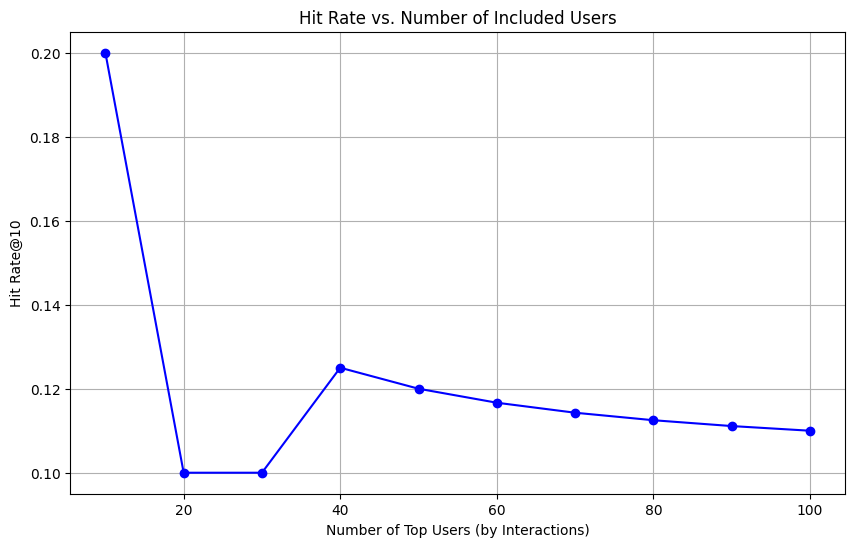

In [24]:
plot_hit_rate_vs_users(positive_test_df, max_users=100, step=10, recommend_func=popularity_based_recommendation)

### Evaluate on new users in the test data

In [25]:
old_user = train_df['user_id'].tolist()
new_user_positive_test_df = positive_test_df[~positive_test_df['user_id'].isin(old_user)]

In [26]:
evaluate_model(popularity_based_recommendation, new_user_positive_test_df, 10)

MAP@10: 0.001453
Precision@10: 0.000723
Recall@10: 0.005841
Hit@10: 0.007167
NDCG@10: 0.002557


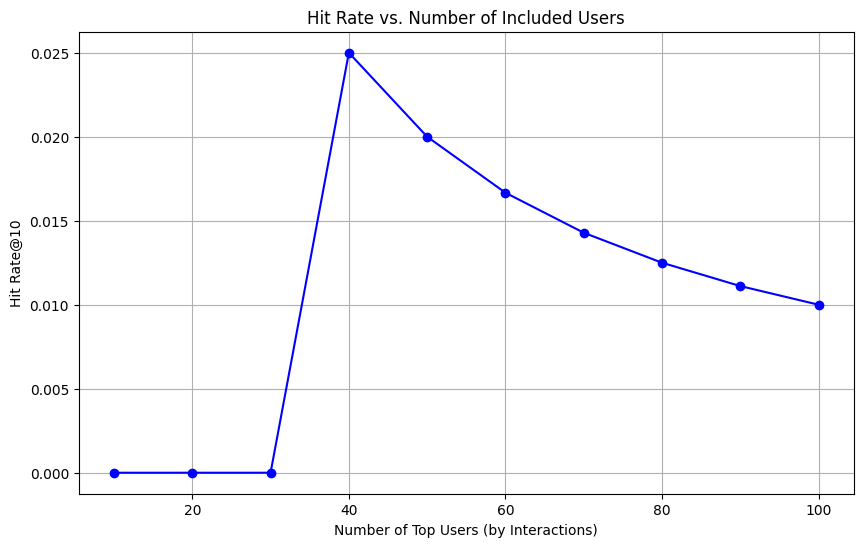

In [27]:
plot_hit_rate_vs_users(new_user_positive_test_df, max_users=100, step=10, recommend_func=popularity_based_recommendation)

### Evaluate on train set

In [28]:
## Randomly sample 1000 users for evaluation
positive_train_df = train_df[train_df['stars_bin']==1]
users = positive_train_df['user_id'].unique()
random_users = np.random.choice(users, size=1000, replace=False)
sampled_positive_train_df = positive_test_df[positive_test_df['user_id'].isin(random_users)]
print(len(sampled_positive_train_df))


125


In [29]:
evaluate_model(popularity_based_recommendation, positive_train_df, 10)

MAP@10: 0.000061
Precision@10: 0.000092
Recall@10: 0.000289
Hit@10: 0.000858
NDCG@10: 0.000151


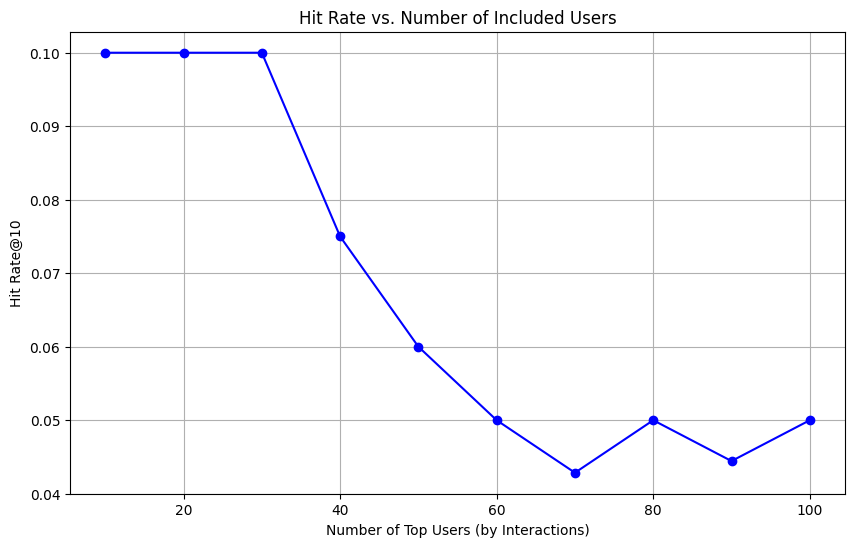

In [30]:
plot_hit_rate_vs_users(positive_train_df, max_users=100, step=10, recommend_func=popularity_based_recommendation)

## Evalaute Popularity based on Review Count
### Evaluate on entire test dataset

In [31]:
evaluate_model(review_count_based_recommendation, positive_test_df, 10)

<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

MAP@10: 0.006741
Precision@10: 0.003394
Recall@10: 0.016902
Hit@10: 0.031426
NDCG@10: 0.010453


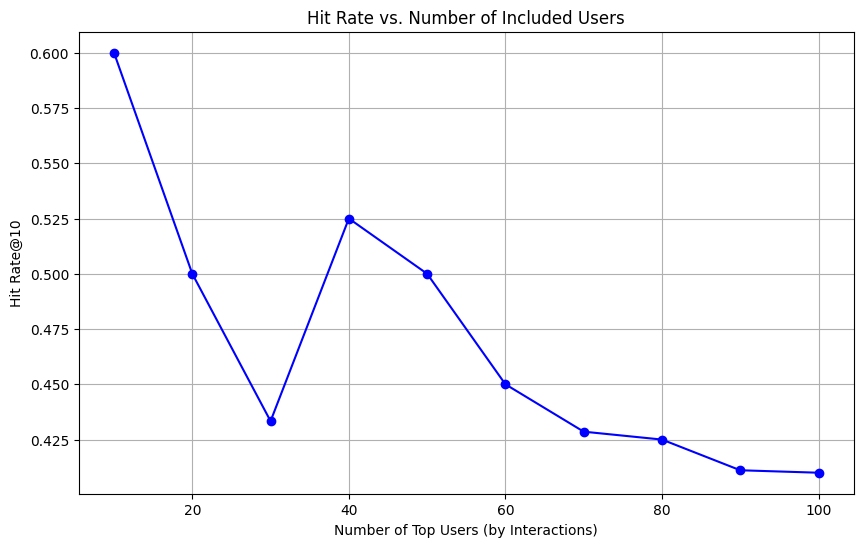

In [32]:
plot_hit_rate_vs_users(positive_test_df, max_users=100, step=10, recommend_func=review_count_based_recommendation)

### Evaluate on new users in the test data

In [33]:
evaluate_model(review_count_based_recommendation, new_user_positive_test_df, 10)

<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

MAP@10: 0.006800
Precision@10: 0.002741
Recall@10: 0.017455
Hit@10: 0.026078
NDCG@10: 0.010091


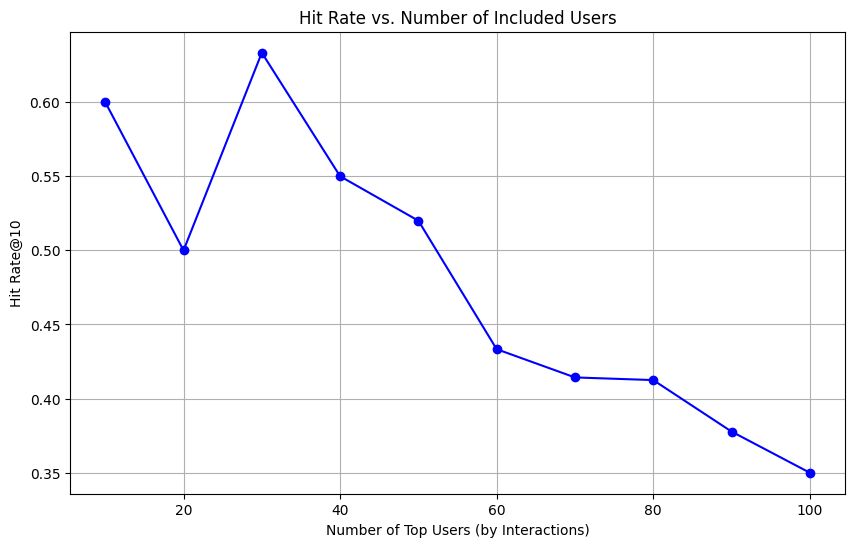

In [34]:
plot_hit_rate_vs_users(new_user_positive_test_df, max_users=100, step=10, recommend_func=review_count_based_recommendation)

### Evaluate on train set

In [35]:
evaluate_model(review_count_based_recommendation, positive_train_df, 10)

<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  restaurant_df['distance'] = np.sqrt((restaurant_df['latitude'] - lat)**2 + (restaurant_df['longitude'] - lon)**2)
<ipython-input-13-cb0fdca3e0da>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a Dat

MAP@10: 0.005211
Precision@10: 0.002568
Recall@10: 0.009730
Hit@10: 0.022705
NDCG@10: 0.007584


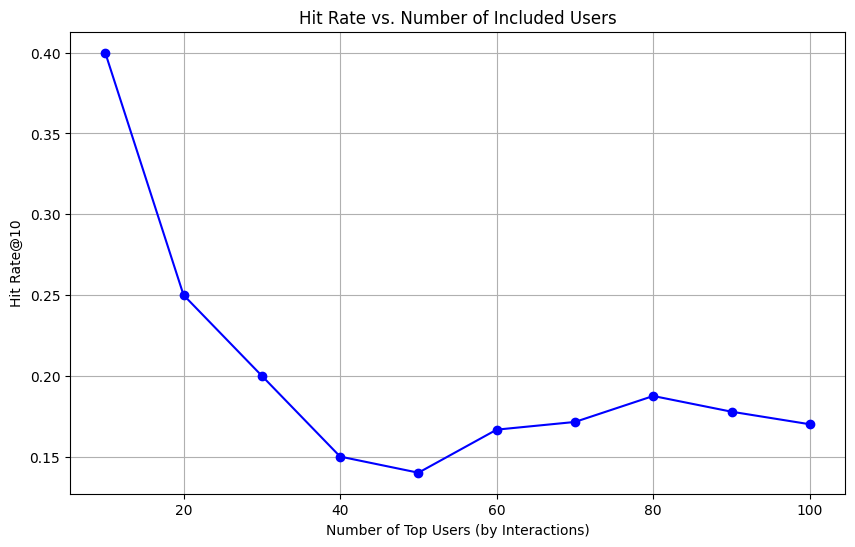

In [36]:
plot_hit_rate_vs_users(positive_train_df, max_users=100, step=10, recommend_func=review_count_based_recommendation)